In [1]:
import numpy as np
import sklearn
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, time, timedelta
from dateutil import tz
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import matplotlib.dates as mdates
import seaborn as sns
import pytz, datetime
import warnings

warnings.filterwarnings('ignore');

MergeListe = []

%matplotlib inline


import itertools
from itertools import *

# Part I - Reading Weather Data

## Reading the weather data files and merging them into one Dataframe

### Important note: all datasets have to be stored in the same repository

1. Import the Data in Panda Dataframe
2. Rename columns
3. Choose relevant time frame
3. Put df into the MergeList

### Importing the air temperature data in °C

In [2]:
#ns Temperature file to be found under: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/stundenwerte_TU_01420_19810101_20181231_hist.zip
#importing only relevant columns
Temp_Dataset = pd.read_csv("Temperatur_tu_stunde_19810101_20181231_01420.txt", 
                header = 0,
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_9",
                        "Temperature",
                        "RelativeAirHumidity",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","Temperature","RelativeAirHumidity"])

#slicing only the relevant timeframe out of "DateTime"
Temp_Dataset = Temp_Dataset[Temp_Dataset["DateTime"] >= 2014123123]
Temp_Dataset = Temp_Dataset[Temp_Dataset["DateTime"] <2016123123]

#format the column "DateTime" and add it as a seperate column
Temp_Dataset["FormattedDate"]= pd.to_datetime(Temp_Dataset['DateTime'], format='%Y%m%d%H')

#ns Strip relevant date information out of date
Temp_Dataset["Month"] = Temp_Dataset["FormattedDate"].dt.strftime('%m') #Month as a number (zero padded)
Temp_Dataset["Weekday"] = Temp_Dataset["FormattedDate"].dt.strftime('%w') #Weekday as number (Monday = 0, Tuesday = 1, ...) 
Temp_Dataset["Hour"] = Temp_Dataset["FormattedDate"].dt.strftime('%H') #Hour as number (zero padded)

#using "DateTime" as the new index
Ind_Dataset = Temp_Dataset.set_index(["DateTime"])

#append the MergeListe with the indexed Dataframe
MergeListe.append(Ind_Dataset)

print(Ind_Dataset)

            Temperature  RelativeAirHumidity       FormattedDate Month  \
DateTime                                                                 
2014123123          1.2                100.0 2014-12-31 23:00:00    12   
2015010100          1.2                100.0 2015-01-01 00:00:00    01   
2015010101          1.1                100.0 2015-01-01 01:00:00    01   
2015010102          1.2                100.0 2015-01-01 02:00:00    01   
2015010103          1.1                100.0 2015-01-01 03:00:00    01   
...                 ...                  ...                 ...   ...   
2016123118         -3.5                 97.0 2016-12-31 18:00:00    12   
2016123119         -3.6                 99.0 2016-12-31 19:00:00    12   
2016123120         -3.5                 99.0 2016-12-31 20:00:00    12   
2016123121         -3.7                 98.0 2016-12-31 21:00:00    12   
2016123122         -3.7                 99.0 2016-12-31 22:00:00    12   

           Weekday Hour  
DateTime   

### Importing the sunshine duration data in minutes per hour

In [3]:
#ns Sunshine data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/sun/historical/stundenwerte_SD_01420_19510101_20181231_hist.zip
#importing only relevant columns, indexing

Sun_Dataset = pd.read_csv("sonne_sd_stunde_19510101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_7",
                        "SunshineDuration",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","SunshineDuration"])

#slicing only the relevant timeframe out of "DateTime"
Sun_Dataset = Sun_Dataset[Sun_Dataset.index>= 2014123123]
Sun_Dataset = Sun_Dataset[Sun_Dataset.index <2016123123]

print(Sun_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Sun_Dataset)

            SunshineDuration
DateTime                    
2015010103               0.0
2015010104               0.0
2015010105               0.0
2015010106               0.0
2015010107               0.0
...                      ...
2016123116               0.0
2016123117               0.0
2016123118               0.0
2016123119               0.0
2016123120               0.0

[13158 rows x 1 columns]


### Importing the total cloud cover data per hour
#### Cloudiness ranked from 0 to 8; -1 for the case that they sky is not visible

In [4]:
#ns cloud data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/cloudiness/historical/stundenwerte_N_01420_19490101_20181231_hist.zip
#importing only relevant columns, indexing
Cloud_Dataset = pd.read_csv("Cloudiness_n_stunde_19490101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_8",
                        "IndexHowMeasurementIsTaken",
                        "TotalCloudCover",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","TotalCloudCover"])

#slicing only the relevant timeframe out of "DateTime"
Cloud_Dataset = Cloud_Dataset[Cloud_Dataset.index>= 2014123123]
Cloud_Dataset = Cloud_Dataset[Cloud_Dataset.index <2016123123]

print(Cloud_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Cloud_Dataset)

            TotalCloudCover
DateTime                   
2014123123                8
2015010100                8
2015010101                8
2015010102               -1
2015010103               -1
...                     ...
2016123118                8
2016123119                8
2016123120                8
2016123121                8
2016123122                8

[17544 rows x 1 columns]


### Importing the precipitation data in mm per hour

In [5]:
#ns Precipitation data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/stundenwerte_RR_01420_19950901_20181231_hist.zip
#importing only relevant columns, indexing
Precipitation_Dataset = pd.read_csv("Niederschlag_rr_stunde_19950901_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_8",
                        "PrecipitationHeight",
                        "PrecipitationBool",
                        "FormOfPrecipitation",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","PrecipitationHeight"])

#slicing only the relevant timeframe out of "DateTime"
Precipitation_Dataset = Precipitation_Dataset[Precipitation_Dataset.index>= 2014123123]
Precipitation_Dataset = Precipitation_Dataset[Precipitation_Dataset.index <2016123123]

print(Precipitation_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Precipitation_Dataset)

            PrecipitationHeight
DateTime                       
2014123123                  0.0
2015010100                  0.0
2015010101                  0.0
2015010102                  0.0
2015010103                  0.0
...                         ...
2016123118                  0.0
2016123119                  0.0
2016123120                  0.0
2016123121                  0.0
2016123122                  0.0

[17536 rows x 1 columns]


### Importing the visibility data in meters

In [6]:
#ns visibility data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/visibility/historical/stundenwerte_VV_01420_19490101_20181231_hist.zip
#importing only relevant columns, indexing
Visibility_Dataset = pd.read_csv("Sicht_vv_stunde_19490101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_8",
                        "IndexHowMeasurementIsTaken",
                        "Visibility",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","Visibility"])
#slicing only the relevant timeframe out of "DateTime"
Visibility_Dataset = Visibility_Dataset[Visibility_Dataset.index>= 2014123123]
Visibility_Dataset = Visibility_Dataset[Visibility_Dataset.index <2016123123]

print(Visibility_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Visibility_Dataset)

            Visibility
DateTime              
2014123123        3500
2015010100        3000
2015010101        1500
2015010102         700
2015010103         600
...                ...
2016123118       32000
2016123119        2600
2016123120        1900
2016123121        1900
2016123122        1900

[17544 rows x 1 columns]


### Importing the wind speed data in meters per second

In [7]:
#ns wind data to be found under https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/wind/historical/stundenwerte_FF_01420_19670101_20181231_hist.zip
#importing only relevant columns, indexing
Wind_Dataset = pd.read_csv("Wind_ff_stunde_19670101_20181231_01420.txt", 
                header = 0,
                index_col="DateTime",
                names = ["MeasuringStation",
                        "DateTime",
                        "QN_3",
                        "MeanWindSpeed",
                        "MeanWindDirection",
                        "eor"], 
                sep=";",
                decimal=".",
                usecols=["DateTime","MeanWindSpeed"])

#slicing only the relevant timeframe out of "DateTime"
Wind_Dataset = Wind_Dataset[Wind_Dataset.index>= 2014123123]
Wind_Dataset = Wind_Dataset[Wind_Dataset.index <2016123123]

print(Wind_Dataset)

#append the MergeListe with the indexed Dataframe
MergeListe.append(Wind_Dataset)

            MeanWindSpeed
DateTime                 
2014123123            1.8
2015010100            1.6
2015010101            1.3
2015010102            1.2
2015010103            1.0
...                   ...
2016123118            2.1
2016123119            1.9
2016123120            1.7
2016123121            1.7
2016123122            2.1

[17544 rows x 1 columns]


## Joining all existing Dataframes (in the MergeListe) by using the indices


In [8]:
#merging the df in the list by using pd.concat
Wetterdaten = pd.concat(MergeListe, axis=1)

#is this necessary?
Wetterdaten['FormattedDate'].dt.strftime('%Y-%m-%d %X')

print (Wetterdaten)
Wetterdaten.describe()

            Temperature  RelativeAirHumidity       FormattedDate Month  \
DateTime                                                                 
2014123123          1.2                100.0 2014-12-31 23:00:00    12   
2015010100          1.2                100.0 2015-01-01 00:00:00    01   
2015010101          1.1                100.0 2015-01-01 01:00:00    01   
2015010102          1.2                100.0 2015-01-01 02:00:00    01   
2015010103          1.1                100.0 2015-01-01 03:00:00    01   
...                 ...                  ...                 ...   ...   
2016123118         -3.5                 97.0 2016-12-31 18:00:00    12   
2016123119         -3.6                 99.0 2016-12-31 19:00:00    12   
2016123120         -3.5                 99.0 2016-12-31 20:00:00    12   
2016123121         -3.7                 98.0 2016-12-31 21:00:00    12   
2016123122         -3.7                 99.0 2016-12-31 22:00:00    12   

           Weekday Hour  SunshineDura

,Temperature,RelativeAirHumidity,SunshineDuration,TotalCloudCover,PrecipitationHeight,Visibility,MeanWindSpeed
count,17544.000000,17544.000000,13158.000000,17544.000000,17536.000000,17544.000000,17544.000000
mean,11.376482,74.607273,14.988524,5.371295,-0.565174,33744.219676,3.404195
std,7.857234,19.438891,22.842231,2.622536,25.018618,18481.061803,2.121886
min,-7.200000,16.000000,0.000000,-1.000000,-999.000000,100.000000,0.000000
25%,5.100000,61.000000,0.000000,3.000000,0.000000,18000.000000,1.800000
50%,10.800000,78.000000,0.000000,7.000000,0.000000,35000.000000,2.900000
75%,16.900000,92.000000,28.000000,7.000000,0.000000,50000.000000,4.500000
max,38.100000,100.000000,60.000000,8.000000,19.100000,81900.000000,18.800000


## Cleaning the data and handling error values
### Assigning numerical error values to 'nan' so that statistical methods are not biased

1. Checking the error values of each data set
<ul>
<li>Temperature Error values are -999</li>
<li>Relative Air humidity error values are -999</li>
<li>Sunshine duration error values are -999</li>
<li>Totalcloudcover error values are -999</li>
<li>Precipitationheight error values are -999</li>
<li>Visibility error values are -999</li>
<li>Meanwindspeed error values are non existent</li>
</ul>


2. All -999 in the dataframe are replaced by NaN
<ul>
<li>Only PrecipitationHeight has error values</li>
<li>Create new dataframe to keep original active and have the new one anyway</li>

In [9]:
Wetterdaten_nand = Wetterdaten.replace(-999,np.NaN)

#Option to overwrite dataframe or not
Wetterdaten = Wetterdaten_nand


In [10]:
Wetterdaten.describe()

,Temperature,RelativeAirHumidity,SunshineDuration,TotalCloudCover,PrecipitationHeight,Visibility,MeanWindSpeed
count,17544.000000,17544.000000,13158.000000,17544.000000,17525.000000,17544.000000,17544.000000
mean,11.376482,74.607273,14.988524,5.371295,0.061518,33744.219676,3.404195
std,7.857234,19.438891,22.842231,2.622536,0.429199,18481.061803,2.121886
min,-7.200000,16.000000,0.000000,-1.000000,0.000000,100.000000,0.000000
25%,5.100000,61.000000,0.000000,3.000000,0.000000,18000.000000,1.800000
50%,10.800000,78.000000,0.000000,7.000000,0.000000,35000.000000,2.900000
75%,16.900000,92.000000,28.000000,7.000000,0.000000,50000.000000,4.500000
max,38.100000,100.000000,60.000000,8.000000,19.100000,81900.000000,18.800000


### Handling missing data
1. Description above shows, that only sunshine and precipitation values are missing. Precipitation is only missing 19 values, <br> these will be filled via forward fill, because the missing values are < 0.2% and we assume some weather stability, rather <br> than to assume 0 or mean values. <br> <br>

2. SunshineDuration is always missing 6h from 9 pm until 3 am. Will be imputed with zeros, because the sun typically does not <br> shine at night in Frankfurt.


In [11]:
#Fill precipitation data
Wetterdaten['PrecipitationHeight'].fillna(method='ffill', inplace=True)

#Fill sunshine data
Wetterdaten['SunshineDuration'].fillna(0, inplace=True)

Wetterdaten.describe()
Wetterdaten.iloc[1224:1260]
Wetterdaten.iloc[9000:9049]

,Temperature,RelativeAirHumidity,FormattedDate,Month,Weekday,Hour,SunshineDuration,TotalCloudCover,PrecipitationHeight,Visibility,MeanWindSpeed
DateTime,,,,,,,,,,,
2016011023,5.4,93.0,2016-01-10 23:00:00,01,0,23,0.0,7,0.0,30000,3.0
2016011100,5.5,95.0,2016-01-11 00:00:00,01,1,00,0.0,7,0.0,30000,2.7
2016011101,5.7,94.0,2016-01-11 01:00:00,01,1,01,0.0,7,0.0,30000,2.9
2016011102,5.7,91.0,2016-01-11 02:00:00,01,1,02,0.0,6,0.0,30000,3.4
2016011103,4.4,93.0,2016-01-11 03:00:00,01,1,03,0.0,5,0.0,40000,3.4
2016011104,3.8,96.0,2016-01-11 04:00:00,01,1,04,0.0,7,0.0,40000,1.6
2016011105,3.1,97.0,2016-01-11 05:00:00,01,1,05,0.0,7,0.0,30000,1.1
2016011106,3.8,97.0,2016-01-11 06:00:00,01,1,06,0.0,7,0.0,30000,1.6
2016011107,4.3,96.0,2016-01-11 07:00:00,01,1,07,0.0,7,0.0,40000,2.3


## Choose Formatted Column as new Index

In [12]:
Ind_Wetterdaten = Wetterdaten.set_index(['FormattedDate'])

Ind_Wetterdaten.head()

,Temperature,RelativeAirHumidity,Month,Weekday,Hour,SunshineDuration,TotalCloudCover,PrecipitationHeight,Visibility,MeanWindSpeed
FormattedDate,,,,,,,,,,
2014-12-31 23:00:00,1.2,100.0,12,3,23,0.0,8,0.0,3500,1.8
2015-01-01 00:00:00,1.2,100.0,01,4,00,0.0,8,0.0,3000,1.6
2015-01-01 01:00:00,1.1,100.0,01,4,01,0.0,8,0.0,1500,1.3
2015-01-01 02:00:00,1.2,100.0,01,4,02,0.0,-1,0.0,700,1.2
2015-01-01 03:00:00,1.1,100.0,01,4,03,0.0,-1,0.0,600,1.0


## Save Dataset in csv in order to allow fast access

In [13]:
Ind_Wetterdaten.to_csv("Datenbasis_Weather_beforePlotting.csv")

# Part II - Plotting Weather Data
## Data visualization for data understanding purposes
### Temperature during the two year period

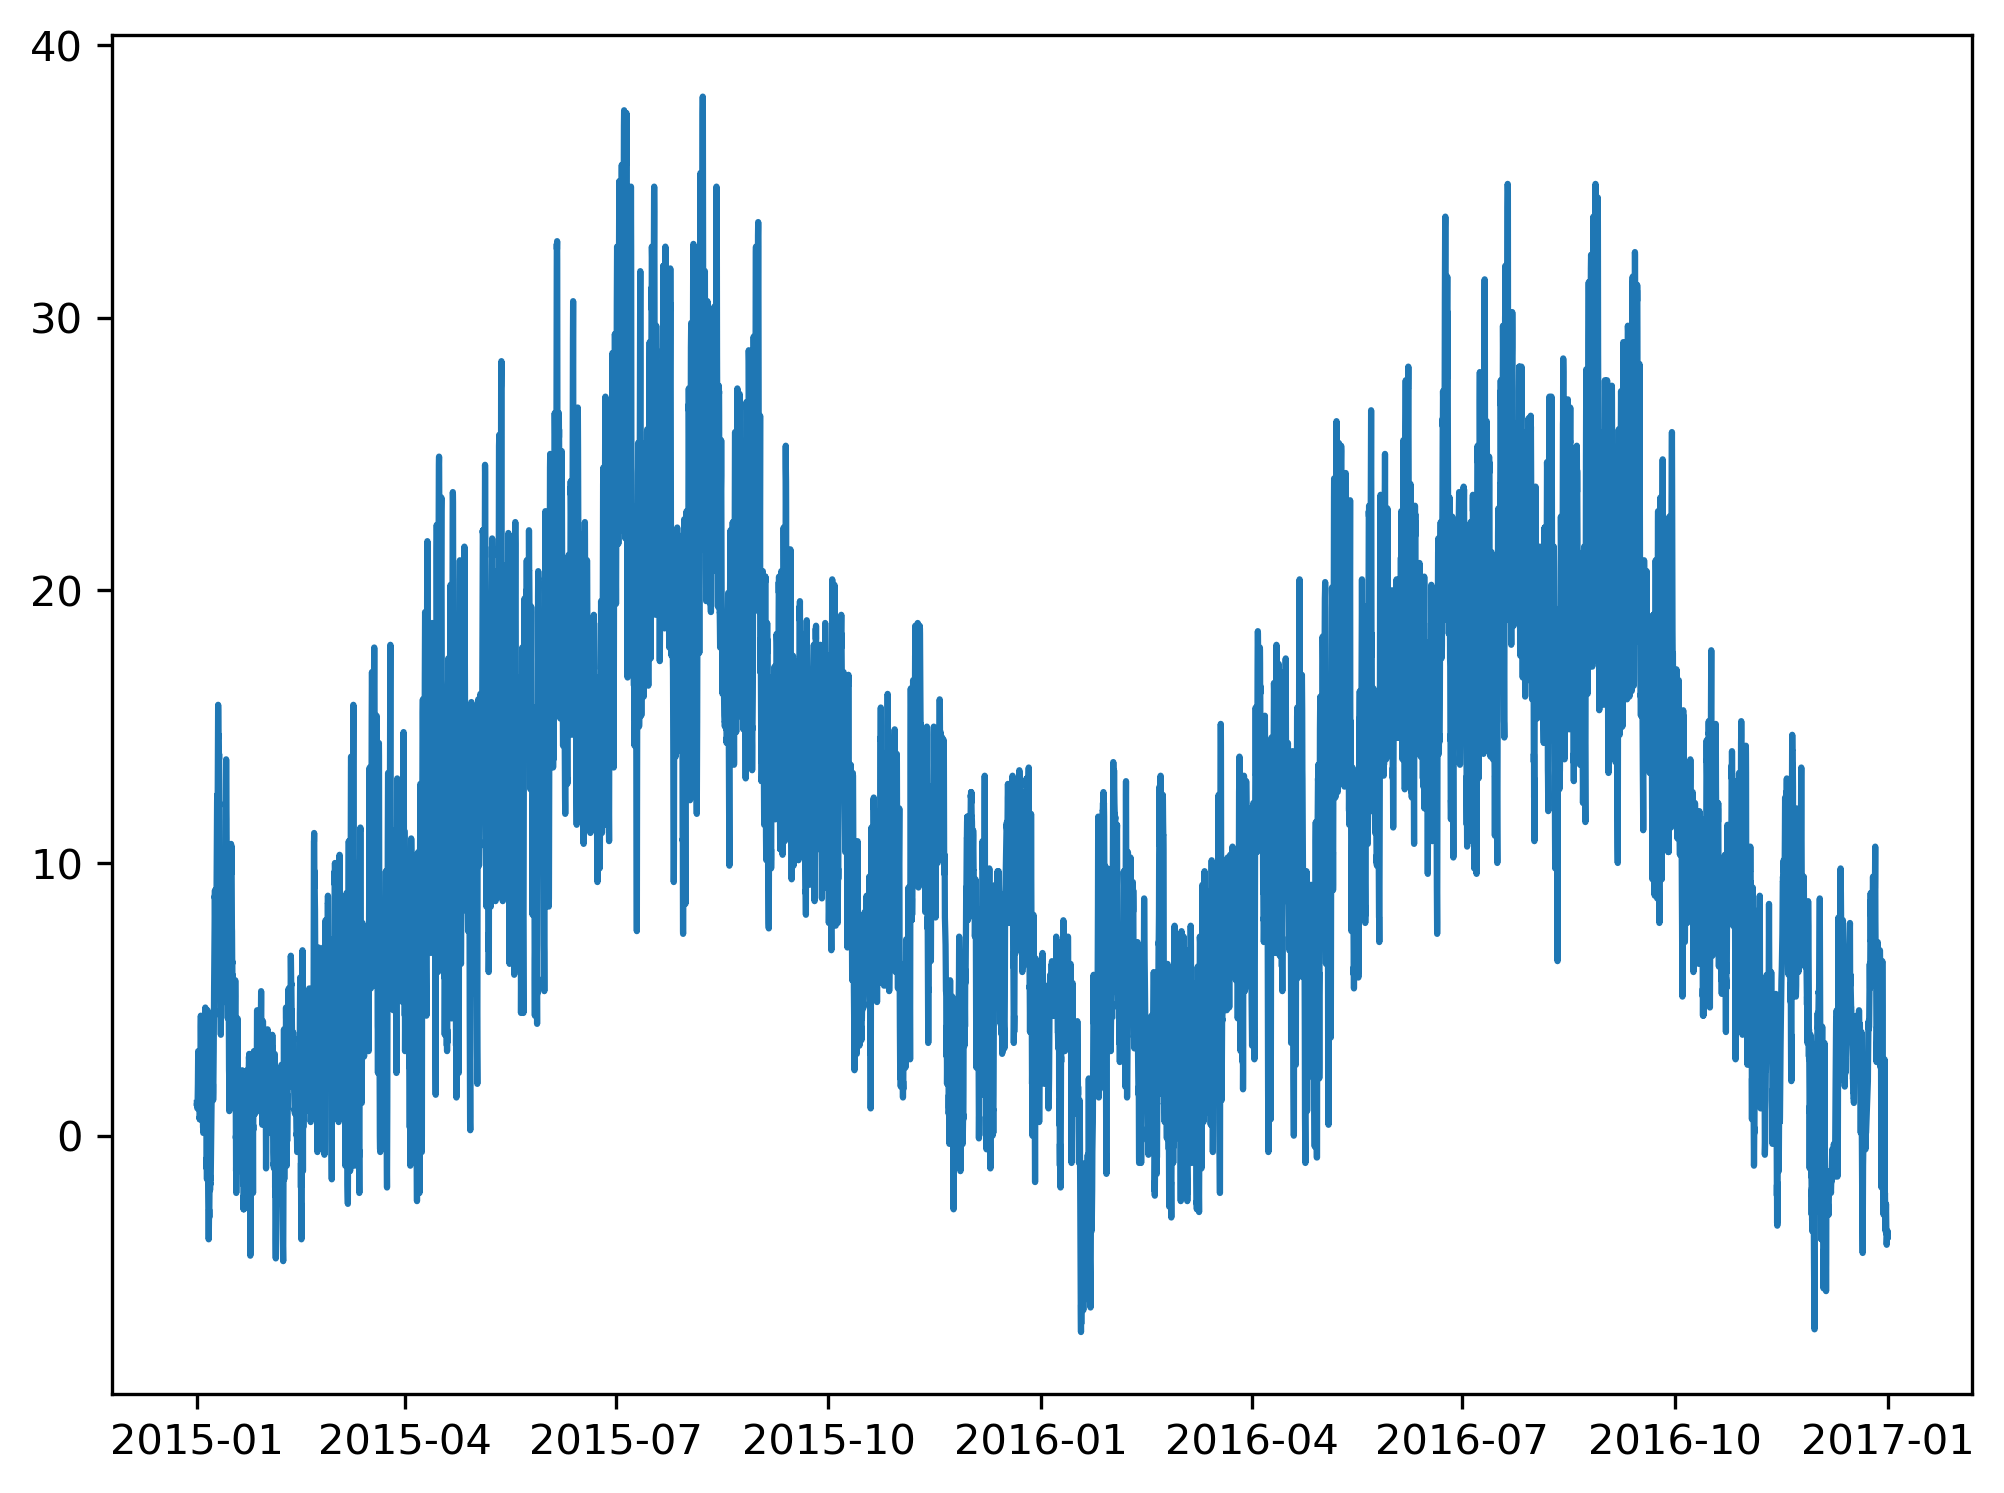

In [14]:
Fig_1 = plt.figure(figsize=(8,6),dpi = 300)
plt.plot(Ind_Wetterdaten.index,Ind_Wetterdaten['Temperature'])
plt.show()

### Development of the temperature on two random days

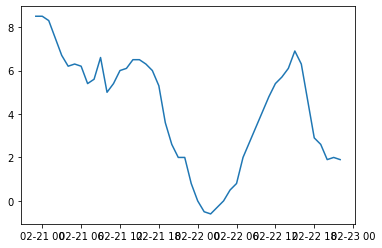

In [15]:
plt.plot(Ind_Wetterdaten.index[1224:1272],Ind_Wetterdaten['Temperature'][1224:1272])
plt.show()

### Development of the precipitation on two random days

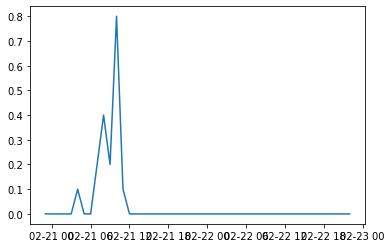

In [16]:
plt.plot(Ind_Wetterdaten.index[1224:1272],Ind_Wetterdaten['PrecipitationHeight'][1224:1272])
plt.show()

### Histogramm of the temperature

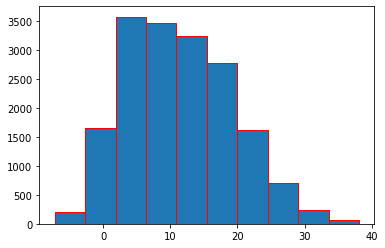

In [17]:
plt.hist(Ind_Wetterdaten['Temperature'], bins=10, edgecolor='red')
plt.show()

# Using the Pearson Correlation
#### BLEIBT NICHT IM NOTEBOOK: Source: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b 

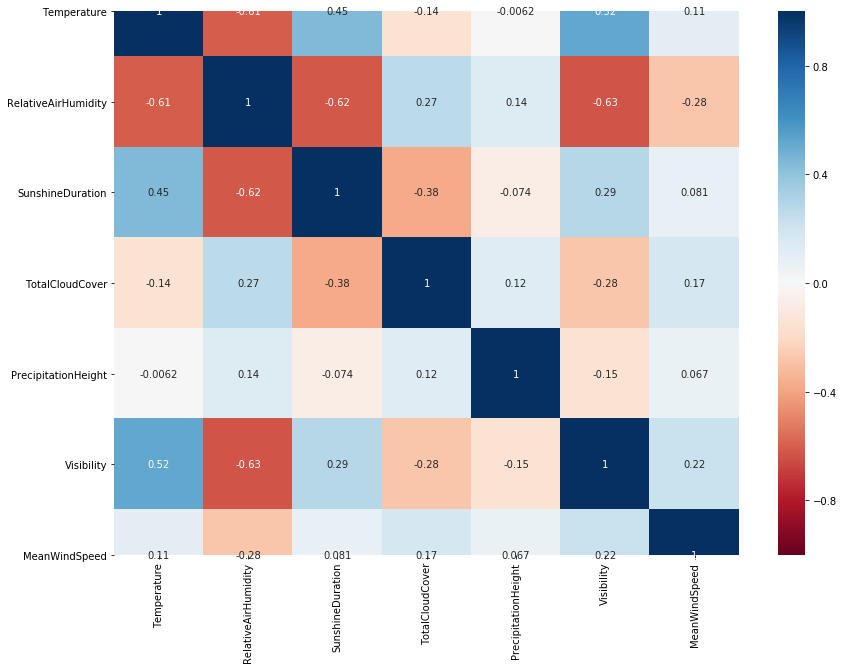

In [18]:
plt.figure(figsize=(14,10))
cor = Ind_Wetterdaten.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
sns.heatmap(cor,vmin=-1, vmax=1, annot=True, cmap="RdBu")
plt.show()

## Creating a new dataframe with only the relevant columns and all rows for now

Die Gründe warum wir Sunshine Duration, Visibility und RelativeAirHumidity raus nehmen:

SM: Due to a high correlation (>0.2) with Temperature and other paramters we decided to put out SunshineDuration, Visibility as well as Relative Air Humidity. This enables us to foucs on the futer feature target (bike rental demand) and provides us pramteters that are undependet from each other. This makes all our futue models more precise. 

In [19]:
Rel_Wetterdaten = Ind_Wetterdaten.loc[:, ['Temperature','TotalCloudCover', 'PrecipitationHeight','MeanWindSpeed','Month','Weekday','Hour']]

Rel_Wetterdaten.head()

#exporting new data as csv
Rel_Wetterdaten.to_csv("Datenbasis_Weather_relevant.csv")

# Part III - Reading Bike Data

## Adding the amount of rented bikes per hour to the weather data set

### Reading the csv file and  choosing only relevant data (Frankfurt and Dates 2015 - 2016)

In [20]:
#reading csv file
booking_set = pd.read_csv("OPENDATA_BOOKING_CALL_A_BIKE.csv", 
                delimiter=';',
                usecols = ["DATE_BOOKING", "CITY_RENTAL_ZONE","START_RENTAL_ZONE"])

#only using the entries that include "Frankfurt"
booking_set_frankfurt = booking_set[booking_set['CITY_RENTAL_ZONE'].str.contains('Frankfurt')]

#only using the column DATE_BOOKING
booking_set_frankfurt = booking_set_frankfurt.loc[:,['DATE_BOOKING','START_RENTAL_ZONE']]

#drop all rows that have empty values (NaN values)
booking_set_frankfurt = booking_set_frankfurt.dropna(axis=0)

#sort the data after the date, ascending
booking_set_frankfurt.sort_values(['DATE_BOOKING'], axis=0, 
                 ascending=True, inplace=True)

#format the column to datetime
booking_set_frankfurt['DATE_BOOKING']= pd.to_datetime(booking_set_frankfurt['DATE_BOOKING'], format='%Y-%m-%d %H')

#only use relevant time frame
start_date_20152016 = '2015-01-01 00:00:00'
end_date_20152016 = '2016-12-31 23:59:59'
filtered_dates_20152016 = (booking_set_frankfurt['DATE_BOOKING'] >= start_date_20152016) & (booking_set_frankfurt['DATE_BOOKING'] <= end_date_20152016)
booking_set_frankfurt_20152016 = booking_set_frankfurt.loc[filtered_dates_20152016]
booking_set_frankfurt_20152016

print (booking_set_frankfurt_20152016)


                DATE_BOOKING                     START_RENTAL_ZONE
4284612  2015-01-01 00:21:22    Speyerer Straße / Koblenzer Straße
4285336  2015-01-01 00:30:20          Roßmarkt / An der Hauptwache
4285873  2015-01-01 00:42:51           Woolworth Leipziger Strasse
4286542  2015-01-01 01:00:19                    Markus-Krankenhaus
4286567  2015-01-01 01:00:47                    Markus-Krankenhaus
...                      ...                                   ...
14613160 2016-12-31 23:13:00  Hauptbahnhof Haupteingang (Vorplatz)
14613511 2016-12-31 23:23:28           Taunusstraße / Gallusanlage
14612056 2016-12-31 23:24:03                Sternstraße / Unterweg
14615815 2016-12-31 23:28:04                Sternstraße / Unterweg
14612244 2016-12-31 23:40:33         Krifteler Straße / Lahnstraße

[1222018 rows x 2 columns]


### Removing the minutes of the time stamp by using the .floor function
 <font color='red'> 
    
## An dieser Stelle müsste die Konvertierung des Zeitformats in UTC passieren. Also bevor die Stunde abgeschnitten wird

In [21]:
#Use the column "DATE_BOOKING" as Index
Ind_Bookings = booking_set_frankfurt_20152016.set_index(['DATE_BOOKING'])
#print (Ind_Bookings)

#in utc umwandeln
Ind_Bookings_UTC = Ind_Bookings.tz_localize(('Europe/Berlin'),ambiguous = "NaT").tz_convert(pytz.utc)
#print (Ind_Bookings_UTC)
#jede buchung ist jetzt utc

#localize wieder löschen, damit lenth of index wieder stimmt 
Ind_Bookings_UTC= Ind_Bookings_UTC.tz_localize(None)
print(Ind_Bookings_UTC)


                                        START_RENTAL_ZONE
DATE_BOOKING                                             
2014-12-31 23:21:22    Speyerer Straße / Koblenzer Straße
2014-12-31 23:30:20          Roßmarkt / An der Hauptwache
2014-12-31 23:42:51           Woolworth Leipziger Strasse
2015-01-01 00:00:19                    Markus-Krankenhaus
2015-01-01 00:00:47                    Markus-Krankenhaus
...                                                   ...
2016-12-31 22:13:00  Hauptbahnhof Haupteingang (Vorplatz)
2016-12-31 22:23:28           Taunusstraße / Gallusanlage
2016-12-31 22:24:03                Sternstraße / Unterweg
2016-12-31 22:28:04                Sternstraße / Unterweg
2016-12-31 22:40:33         Krifteler Straße / Lahnstraße

[1222018 rows x 1 columns]


## Removing the minutes of the time stamp by using the .floor function

In [22]:
Ind_Bookings_UTC.index = pd.to_datetime(Ind_Bookings_UTC.index).floor('h')

#ns second dataframe for different aggregation
Ind_Bookings_Stations_UTC = Ind_Bookings_UTC

#ns following code is necessary to recreate the empty dataframe without the station and with only the datetimes as index
lst = []
lst = Ind_Bookings_UTC.index
Ind_Bookings_UTC_new = pd.DataFrame(lst)
Ind_Bookings_UTC_new = Ind_Bookings_UTC_new.set_index(['DATE_BOOKING'])
Ind_Bookings_UTC = Ind_Bookings_UTC_new

print (Ind_Bookings_UTC)

Empty DataFrame
Columns: []
Index: [2014-12-31 23:00:00, 2014-12-31 23:00:00, 2014-12-31 23:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 00:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 01:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00, 2015-01-01 02:00:00

### Group the Dataframe by its Date (Hour of Booking) to generate a column counting the amount of rentals per hour

In [23]:
Ind_Bookings_UTC['Rentals'] =Ind_Bookings_UTC.groupby('DATE_BOOKING').size()
Ind_Bookings_UTC.groupby('DATE_BOOKING')
print (Ind_Bookings_UTC)

                     Rentals
DATE_BOOKING                
2014-12-31 23:00:00      3.0
2014-12-31 23:00:00      3.0
2014-12-31 23:00:00      3.0
2015-01-01 00:00:00      9.0
2015-01-01 00:00:00      9.0
...                      ...
2016-12-31 22:00:00      7.0
2016-12-31 22:00:00      7.0
2016-12-31 22:00:00      7.0
2016-12-31 22:00:00      7.0
2016-12-31 22:00:00      7.0

[1222018 rows x 1 columns]


In [24]:
Ind_Bookings_Stations_UTC["zeitspalte"] = Ind_Bookings_Stations_UTC.index

Ind_Bookings_Stations_UTC['Rentals'] = 1

ser23 = Ind_Bookings_Stations_UTC.groupby(['zeitspalte','START_RENTAL_ZONE'])['Rentals'].sum()

#frame = {'DATE_BOOKING': ser23['zeitspalte'],
 #       'START_RENTAL_ZONE': ser23['START_RENTAL_ZONE'],
  #      'Rentals': ser23['Rentals']}

Ind_Bookings_Stations_UTC_new = pd.DataFrame(ser23)
check = Ind_Bookings_Stations_UTC_new.reset_index(inplace=True)
check

Ind_Bookings_Stations_UTC_new = Ind_Bookings_Stations_UTC_new.rename(columns={"zeitspalte": "DATE_BOOKING"})

Ind_Bookings_Stations_UTC_new = Ind_Bookings_Stations_UTC_new.set_index(['DATE_BOOKING'])

Ind_Bookings_Stations_UTC = Ind_Bookings_Stations_UTC_new



#ns inspiration code

#df.rename(columns={"A": "a", "B": "c"})
#test=pd.DataFrame(data)
#check=test.reset_index(inplace=True)
#check
#group_data = df.groupby(['Alphabet','Words'])['COUNTER'].sum()
#df.groupby(['col5','col2']).size().reset_index().groupby('col2')[[0]].max()
#data.groupby(['month', 'item'])['date'].count()
#df = df.groupby(['Date', 'Groups']).sum().sum(level=['Date', 'Groups']).unstack('Groups').fillna(0).reset_index()

### Join the weather and bike data and drop the duplicates

In [25]:
#create a zeitspalte to help identify duplicate rows
Ind_Bookings_UTC["zeitspalte"] = Ind_Bookings_UTC.index
Ind_Bookings_UTC.drop_duplicates(keep = "first", inplace = True)

#Ind_Bookings_UTC["Weekday"] = Ind_Bookings_UTC["zeitspalte"].dt.tz.weekday() 
#ns extracting the weekday out of the date (Monday = 0, Tuesday =1, etc.)
#Ind_Bookings_UTC.["Season"]
#Ind_Bookings_UTC.["Hour"]


print(Ind_Bookings_UTC)



                     Rentals          zeitspalte
DATE_BOOKING                                    
2014-12-31 23:00:00      3.0 2014-12-31 23:00:00
2015-01-01 00:00:00      9.0 2015-01-01 00:00:00
2015-01-01 01:00:00     15.0 2015-01-01 01:00:00
2015-01-01 02:00:00     19.0 2015-01-01 02:00:00
2015-01-01 03:00:00     13.0 2015-01-01 03:00:00
...                      ...                 ...
2016-12-31 18:00:00     10.0 2016-12-31 18:00:00
2016-12-31 19:00:00     10.0 2016-12-31 19:00:00
2016-12-31 20:00:00     13.0 2016-12-31 20:00:00
2016-12-31 21:00:00     10.0 2016-12-31 21:00:00
2016-12-31 22:00:00      7.0 2016-12-31 22:00:00

[17349 rows x 2 columns]


In [66]:
Datenbasis = Rel_Wetterdaten.join(Ind_Bookings_UTC)
Datenbasis = Datenbasis.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour", "Rentals"]]

Datenbasis.describe()

#ns impute nan values for rentals as 0, because there are no bookings in this hour
Datenbasis['Rentals'].fillna(0, inplace=True)

print(Datenbasis)

Datenbasis.to_csv("DataBase_WeatherRentalAmount_UTC.csv")

Datenbasis2 = Rel_Wetterdaten.join(Ind_Bookings_UTC)
#Datenbasis2 = Datenbasis2.reset_index()
Datenbasis2 = Datenbasis2.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour", "Rentals"]]

Datenbasis6 = Rel_Wetterdaten.join(Ind_Bookings_UTC)
#Datenbasis6 = Datenbasis6.reset_index()
Datenbasis6 = Datenbasis6.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour", "Rentals"]]

Datenbasis24 = Rel_Wetterdaten.join(Ind_Bookings_UTC)
#Datenbasis24 = Datenbasis24.reset_index()
Datenbasis24 = Datenbasis24.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour", "Rentals"]]

#formatieren der strings in integer

Datenbasis['Month'] = Datenbasis2['Month'].astype(int)
Datenbasis['Weekday'] = Datenbasis2['Weekday'].astype(int)
Datenbasis['Hour'] = Datenbasis2['Hour'].astype(int)

Datenbasis2['Month'] = Datenbasis2['Month'].astype(int)
Datenbasis2['Weekday'] = Datenbasis2['Weekday'].astype(int)
Datenbasis2['Hour'] = Datenbasis2['Hour'].astype(int)

Datenbasis6['Month'] = Datenbasis6['Month'].astype(int)
Datenbasis6['Weekday'] = Datenbasis6['Weekday'].astype(int)
Datenbasis6['Hour'] = Datenbasis6['Hour'].astype(int)

Datenbasis24['Month'] = Datenbasis24['Month'].astype(int)
Datenbasis24['Weekday'] = Datenbasis24['Weekday'].astype(int)
Datenbasis24['Hour'] = Datenbasis24['Hour'].astype(int)

                     Temperature  TotalCloudCover  PrecipitationHeight  \
FormattedDate                                                            
2014-12-31 23:00:00          1.2                8                  0.0   
2015-01-01 00:00:00          1.2                8                  0.0   
2015-01-01 01:00:00          1.1                8                  0.0   
2015-01-01 02:00:00          1.2               -1                  0.0   
2015-01-01 03:00:00          1.1               -1                  0.0   
...                          ...              ...                  ...   
2016-12-31 18:00:00         -3.5                8                  0.0   
2016-12-31 19:00:00         -3.6                8                  0.0   
2016-12-31 20:00:00         -3.5                8                  0.0   
2016-12-31 21:00:00         -3.7                8                  0.0   
2016-12-31 22:00:00         -3.7                8                  0.0   

                     MeanWindSpeed Mo

In [67]:
Datenbasis_Stations = Ind_Bookings_Stations_UTC.join(Rel_Wetterdaten)
Datenbasis_Stations = Datenbasis_Stations.loc[:,['Temperature' , 'TotalCloudCover', 'PrecipitationHeight', "MeanWindSpeed", "Month", "Weekday", "Hour", "START_RENTAL_ZONE", "Rentals"]]

Datenbasis_Stations.describe()

print(Datenbasis_Stations)

Datenbasis_Stations.to_csv("DataBase_WeatherRentalAmountStations_UTC.csv")

                     Temperature  TotalCloudCover  PrecipitationHeight  \
2014-12-31 23:00:00          1.2                8                  0.0   
2014-12-31 23:00:00          1.2                8                  0.0   
2014-12-31 23:00:00          1.2                8                  0.0   
2015-01-01 00:00:00          1.2                8                  0.0   
2015-01-01 00:00:00          1.2                8                  0.0   
...                          ...              ...                  ...   
2016-12-31 22:00:00         -3.7                8                  0.0   
2016-12-31 22:00:00         -3.7                8                  0.0   
2016-12-31 22:00:00         -3.7                8                  0.0   
2016-12-31 22:00:00         -3.7                8                  0.0   
2016-12-31 22:00:00         -3.7                8                  0.0   

                     MeanWindSpeed Month Weekday Hour  \
2014-12-31 23:00:00            1.8    12       3   23 

# [Part IV - Playing around a bit by Nina and Zophia]

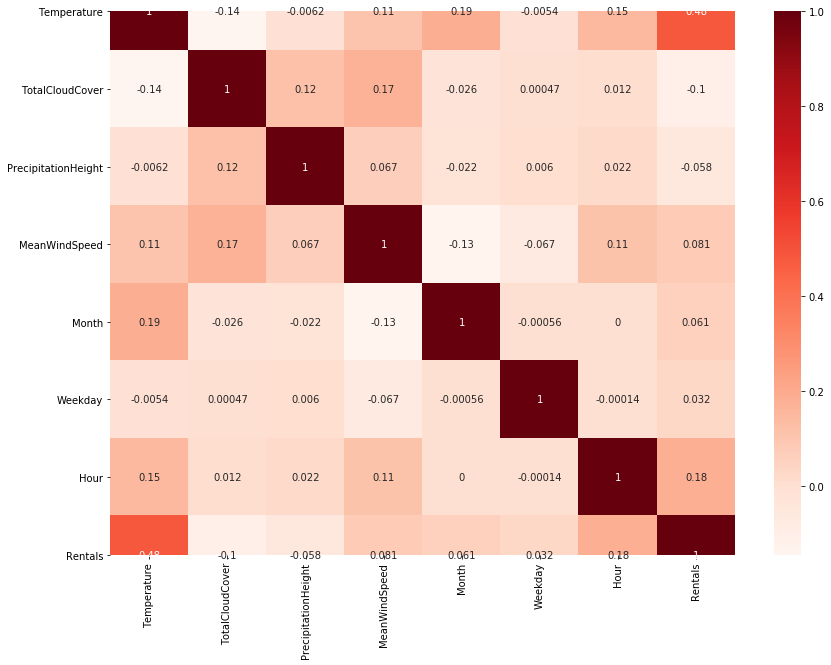

In [68]:
plt.figure(figsize=(14,10))
cor = Datenbasis.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Aggregating the data to a two, six, 24 hour horizon

In [69]:
Datenbasis["Zeitspalte"] = Datenbasis.index

Datenbasis_2a = pd.DataFrame()
Last_Line = {'FormattedDate':['2016-12-31 23:00:00']}
Last_Line = pd.DataFrame(Last_Line)

Datenbasis_2a = Datenbasis[1::2]["Zeitspalte"]

Datenbasis_2a = Datenbasis_2a.append(Last_Line)

Datenbasis_2b = Datenbasis.groupby(pd.RangeIndex(len(Datenbasis)) // 2).mean()
Datenbasis_2b["Rentals"]= np.multiply(Datenbasis_2b["Rentals"],2)


In [70]:
Datenbasis_24h = Datenbasis.resample('D').mean()
Datenbasis_24h['Rentals'] = np.multiply(Datenbasis_24h['Rentals'],24)
Datenbasis_24h['Rentals'].iloc[0]= np.multiply(Datenbasis_24h['Rentals'].iloc[0], 1/24)
Datenbasis_24h['Zeitspalte'] = Datenbasis_24h.index
Datenbasis_24h["Month"] = Datenbasis_24h["Zeitspalte"].dt.strftime('%m') #Month as a number (zero padded)
Datenbasis_24h["Weekday"] = Datenbasis_24h["Zeitspalte"].dt.strftime('%w') #Weekday as number (Monday = 0, Tuesday = 1, ...) 
Datenbasis_24h = Datenbasis_24h.loc[:,["Temperature", "TotalCloudCover","PrecipitationHeight", "MeanWindSpeed", "Rentals", "Month", "Weekday"]]

In [71]:
Datenbasis_24h

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Rentals,Month,Weekday
FormattedDate,,,,,,,
2014-12-31,1.200000,8.000000,0.000000,1.800000,3.000000,12,3
2015-01-01,1.970833,5.583333,0.000000,2.558333,166.000000,01,4
2015-01-02,2.350000,6.791667,0.266667,6.108333,252.000000,01,5
2015-01-03,1.295833,7.333333,0.475000,3.150000,133.000000,01,6
2015-01-04,3.329167,6.416667,0.008333,4.458333,252.000000,01,0
...,...,...,...,...,...,...,...
2016-12-27,5.079167,6.125000,0.000000,4.716667,592.000000,12,2
2016-12-28,4.783333,7.000000,0.000000,2.091667,700.000000,12,3
2016-12-29,1.487500,0.791667,0.000000,1.929167,722.000000,12,4


In [72]:

#da ich probleme beim kopieren habe werden oben 3 identische dataframes erstellt um diese jetzt zu gruppieren

In [73]:
N = len(Datenbasis.index) 
R = int(N/2)
Datenbasis2['grp'] = list(itertools.chain.from_iterable([x]*2 for x in range(0, R)))
Datenbasis2 = Datenbasis2.groupby('grp').mean()
Datenbasis2['PrecipitationHeight'] = Datenbasis2['PrecipitationHeight'] * 2
Datenbasis2['Rentals'] = Datenbasis2['Rentals'] * 2
Datenbasis2.drop(columns=['Hour'], inplace=True)
Datenbasis2.fillna(0, inplace=True)
Datenbasis2.to_csv("DataBase_WeatherRentalAmount_2h_UTC.csv")
#Datenbasis2.head

In [74]:
Datenbasis2.describe()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Rentals
count,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000,8772.000000
mean,11.376482,5.371295,0.123347,3.404195,6.519836,3.008037,139.367875
std,7.839789,2.546550,0.733339,2.085740,3.448657,1.969271,128.817396
min,-7.050000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.100000,3.500000,0.000000,1.850000,4.000000,1.000000,40.000000
50%,10.800000,6.500000,0.000000,2.900000,7.000000,3.000000,103.000000
75%,16.950000,7.000000,0.000000,4.500000,10.000000,5.000000,203.000000
max,37.950000,8.000000,32.500000,17.450000,12.000000,6.000000,792.000000


In [75]:
R = int(N/6)

Datenbasis6['grp'] = list(itertools.chain.from_iterable([x]*6 for x in range(0, R)))
Datenbasis6 = Datenbasis6.groupby('grp').mean()
Datenbasis6['PrecipitationHeight'] = Datenbasis6['PrecipitationHeight'] * 6
Datenbasis6['Rentals'] = Datenbasis6['Rentals'] * 6
Datenbasis6.drop(columns=['Hour'], inplace=True)
Datenbasis6.fillna(0, inplace=True)
Datenbasis6.to_csv("DataBase_WeatherRentalAmount_6h_UTC.csv")


In [76]:
Datenbasis6.describe()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Rentals
count,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000
mean,11.376482,5.371295,0.370041,3.404195,6.519836,3.008037,418.388440
std,7.720378,2.370696,1.490533,1.976931,3.448323,1.948290,342.948602
min,-6.150000,-1.000000,0.000000,0.200000,1.000000,0.000000,0.000000
25%,5.133333,3.666667,0.000000,1.933333,4.000000,1.000000,134.000000
50%,10.850000,6.166667,0.000000,2.883333,7.000000,3.000000,345.500000
75%,16.916667,7.166667,0.000000,4.433333,10.000000,5.000000,599.000000
max,36.433333,8.000000,38.100000,15.883333,12.000000,6.000000,1706.000000


In [77]:
R = int(N/24)

Datenbasis24['grp'] = list(itertools.chain.from_iterable([x]*24 for x in range(0, R)))
Datenbasis24.head
Datenbasis24 = Datenbasis24.groupby('grp').mean()
Datenbasis24['PrecipitationHeight'] = Datenbasis24['PrecipitationHeight'] * 24
Datenbasis24['Rentals'] = Datenbasis24['Rentals'] * 24
Datenbasis24.drop(columns=['Hour'], inplace=True)
Datenbasis24.fillna(0, inplace=True)
Datenbasis24.to_csv("DataBase_WeatherRentalAmount_24h_UTC.csv")
Datenbasis24.head

<bound method NDFrame.head of      Temperature  TotalCloudCover  PrecipitationHeight  MeanWindSpeed  \
grp                                                                     
0       1.941667         5.583333                  0.0       2.412500   
1       2.329167         7.000000                  6.4       6.212500   
2       1.308333         7.166667                 11.4       3.050000   
3       3.325000         6.416667                  0.2       4.470833   
4       0.637500         2.875000                  0.0       2.587500   
..           ...              ...                  ...            ...   
726     5.125000         6.166667                  0.0       4.762500   
727     4.829167         6.833333                  0.0       2.208333   
728     1.666667         1.083333                  0.0       1.850000   
729    -1.458333         0.000000                  0.0       2.091667   
730    -3.445833         6.500000                  0.0       2.166667   

         Month   Wee

In [78]:
Datenbasis24.describe()

,Temperature,TotalCloudCover,PrecipitationHeight,MeanWindSpeed,Month,Weekday,Rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,11.376482,5.371295,1.480164,3.404195,6.519836,3.008037,1683.752340
std,7.247375,1.958596,3.556072,1.635631,3.449820,1.941275,916.656171
min,-5.683333,0.000000,0.000000,1.058333,1.000000,0.250000,0.000000
25%,5.318750,4.208333,0.000000,2.227083,3.979167,0.958333,967.727273
50%,10.941667,5.916667,0.000000,3.033333,7.000000,2.958333,1559.000000
75%,17.004167,6.875000,1.100000,4.135417,9.958333,4.958333,2094.086957
max,29.925000,8.000000,44.700000,10.650000,12.000000,5.958333,4413.913043
